revision information:
- Oct. 4th. 2018 [first version]
- Oct. 25th. 2018

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#  Linear regression

- The fMRI data is time series data. The main goal of fMRI data analysis is to model the meaningful patterns (brain network or circuit) on data which induced by specific event or certain brain state to understand how the brain responding according to the events or states.
- Regression analysis is a one of set of statistical tool for estimating the relationships among variable. It means it can also estimate the relationships between the time-series fMRI data we aquired with our models.
- The most typical example of using linear regression analysis for fMRI is estimating 
    - the nuisance noise caused by head motion to remove it from the data on preprocessing step and
    - the brain regions that respond follow by the external stimulation.

- The general linear model (GLM) is a method that uses linear regression analysis and brain reaction model. It is the most representative method used to measure the correlation between the model and response in the data.
- This approach is based on the assumption that the fMRI signal is linear system (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3359416/#R9) as below.


\begin{align}
Y & = \beta X + \epsilon
\end{align}

- where $Y$ is the signal we acquired from fMRI, $X$ is the model matrix with the size of number of model $\times$ acquisition time, $\beta$ is the vector of coefficient with the size of number of model, which we want to estimate from the analysis. lastly, $\epsilon$ is the error term that has gaussian distribution.

### Learning objectives

After study of the assigned learning materials, the student will know:
1. How to generate fake data to start this learning material.
2. How to perform Polynomial regression to estimate low frequency noise from the data to remove it.
3. How to build a model to integrate GLM analysis for the task-base fMRI analysis. and estimating response strength based on response model.

### Generating fake fMRI time-seris data using GLM concept.

- Before we start, we will generate fake data based on the GLM equation.
- It will help you to understand what the model is, and how the signal fomulated.


- Below image is showing the block paradigm that we want to stimuly to the subject.
<img src="images/figure_4-1.png" alt="Drawing" style="width: 400px;"/>

- Let's create the model for this.
- First, we need timepoints, the last time point will 128 since 

In [2]:
TR = 2 # sampling rate parameter of fMRI image
x = np.arange(0, 130, TR)
print(x)

[  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128]


- Then we will create the block paradigm for our experiments

(0, 128)

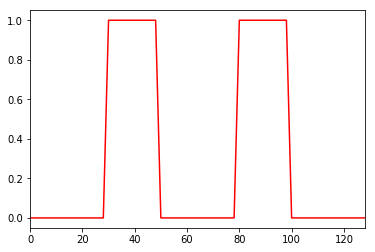

In [3]:
rest = np.zeros(15)
stim = np.ones(10)
block_design = np.concatenate([rest, stim, rest, stim, rest])
plot(x, block_design, '-r')
plt.xlim([0, 128])

- As you already know, the signal we aquire from fMRI is hemodynamic response thorugh neurovascular coupling. In order to model responses, we need to convolute hemodynamic response function(HRF) to make more similar with actual response.


- HRF is typically looks as below, and it's relativly slow response.
<img src="images/figure_4-2.png" alt="Drawing" style="width: 300px;"/>


- Let's make the python function to reproduce this hemodynamic response function. As you can see, the HRF can be simply modeled with two gamma function.

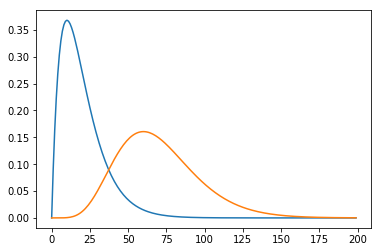

In [4]:
from scipy import stats

timeset = np.arange(0, 20, 0.1)
for i in np.arange(2, 10, 5):
    plot(stats.gamma.pdf(timeset, i))

In [5]:
def HRF(x): # HRF function with two gamma function (arbiturary coded)
    peak = stats.gamma.pdf(x, 5)
    undershoot = stats.gamma.pdf(x, 10)
    hrf = peak - (undershoot/4)
    return hrf / np.max(hrf)

(0, 20)

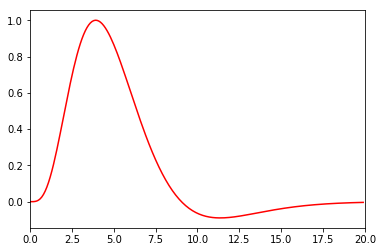

In [6]:
plot(timeset, HRF(timeset), '-r')
plt.xlim([0, 20])

- Now let's perform convolution this function to our model! Before convolve, we need to make the function has same sample size as our data.

(0, 18)

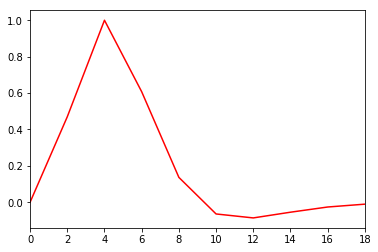

In [7]:
timeset = np.arange(0, 20, TR)
plot(timeset, HRF(timeset), '-r')
plt.xlim([0, 18])

(0, 128)

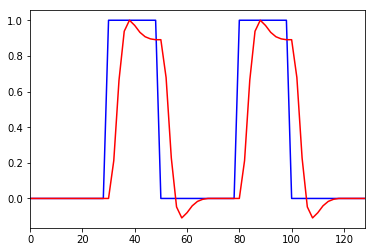

In [8]:
# convolute HRF into block_design
response_model = np.convolve(block_design, HRF(timeset))
# normalize to 1
response_model /= np.max(response_model) 
trimmed_response_model = response_model[:len(block_design)]

plot(x, block_design, '-b', 
     x, trimmed_response_model, '-r')
plt.xlim([0, 128])

- As you recognize, I applied index to truncate the size of the response_model. It because the number of sample can be increased by vecter_size of convoluting function - 1 because the function will be applied on each sample point.

In [9]:
a = len(block_design)
b = len(response_model)
c = len(HRF(timeset))

print('A: Number of sample in block design = {}'.format(a))
print('B: Number of sample in respnse model = {}'.format(b))
print('C: Number of sample in HRF = {}'.format(c))
print('Difference: B - A = C - 1 [{}]'.format((b-a) == (c-1)))

A: Number of sample in block design = 65
B: Number of sample in respnse model = 74
C: Number of sample in HRF = 10
Difference: B - A = C - 1 [True]


- Now we are creating random noise with gaussian shape to model error.
- Below is some example to show how to put two plot on one figure

(0, 128)

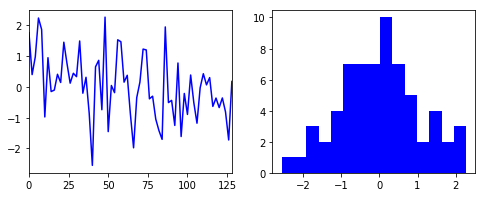

In [10]:
np.random.seed(0)
error = np.random.normal(loc=0, scale=1, size=len(x))

fig, ax= plt.subplots(1, 2, figsize=[8, 3])
ax[0].plot(x, error, '-b')
ax[1].hist(error, bins=15, color='b')
ax[0].set_xlim([0, 128])

- Then we are setting the noise to signal ratio at 4

In [11]:
SNR = 3.5
signal_strength = np.max(trimmed_response_model)
error = error / error.std() * signal_strength / SNR

- Now add into our model

(0, 128)

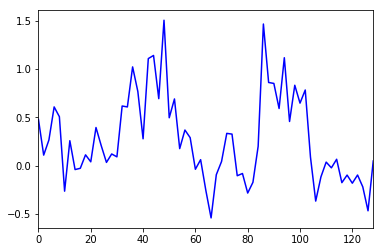

In [12]:
bold = trimmed_response_model + error
plot(x, bold, '-b')
plt.xlim([0, 128])

- and we add more baseline trend using second order polinomial curve
- following code is the code to model polinomial matrix, just keep as reference.

In [13]:
from sklearn.preprocessing import PolynomialFeatures
pn_model = PolynomialFeatures(degree=2)
pn_curves = pn_model.fit_transform(x[:, np.newaxis])
pn_curves /= pn_curves.max(axis = 0)

(0, 128)

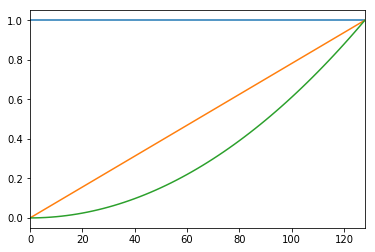

In [14]:
plot(x, pn_curves)
plt.xlim([0, 128])

- We are going to combine this models to create baseline trend. (in fMRI this is usually happen due to the physiological changes such as temperature)
- Let's generate random float values to randomize the strength of trend

(0, 128)

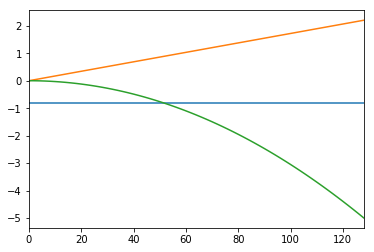

In [15]:
np.random.seed(1)
rand_coeff = np.random.uniform(-5, 5, 3)
trend = pn_curves * rand_coeff
plot(x, trend)
plt.xlim(0, 128)

- After averaging them, you will get random baseline trend from the second order polynomial curve models.

(0, 128)

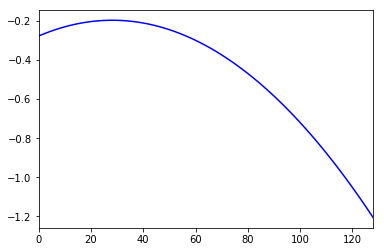

In [16]:
trend = trend.mean(-1)
plot(x, trend, 'blue')
plt.xlim(0, 128)

(0, 128)

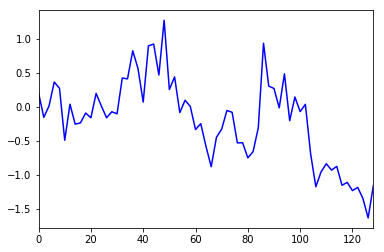

In [17]:
bold = bold + trend
plot(x, bold, 'blue')
plt.xlim(0, 128)

- Now it obiously looks like real data. Let's start from here!
- From here, all process we applied above will be processed inversivly, and this is how we estimating the strength of response.

## task-base fMRI analysis tutorial using fake data

- In this material, we are assuming that we are analyzing only one voxel that shows response.
- Typically, following process need to be performed across voxels in the brain.
- For the first step, as we add the baseline trend, we need to regressed out.

- Below code is wrote to estimate baseline trend using second order polinomial regression.
    - np.newaxis is useful tool when you want to extend axis using indexing.
    - We are just making new axis without adding data because the following command required 2D matrix, with shape of $n \times m$, as its input argument.

In [18]:
X = x[:, np.newaxis]

- Below code pulling the design matrix from previous section of polynomial feature creaion.

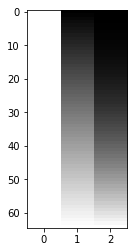

In [19]:
design_matrix = pn_curves
imshow(design_matrix, aspect=0.1, cmap='gray')

- Using this model, we are estimating baseline trend with ordinary least squre estimator.

In [20]:
from sklearn.linear_model import LinearRegression
estimator = LinearRegression() # initiating estimator

In [21]:
help(estimator.fit) # always use help function if you dont know what I'm doing here.

Help on method fit in module sklearn.linear_model.base:

fit(self, X, y, sample_weight=None) method of sklearn.linear_model.base.LinearRegression instance
    Fit linear model.
    
    Parameters
    ----------
    X : numpy array or sparse matrix of shape [n_samples,n_features]
        Training data
    
    y : numpy array of shape [n_samples, n_targets]
        Target values. Will be cast to X's dtype if necessary
    
    sample_weight : numpy array of shape [n_samples]
        Individual weights for each sample
    
        .. versionadded:: 0.17
           parameter *sample_weight* support to LinearRegression.
    
    Returns
    -------
    self : returns an instance of self.



In [22]:
estimator.fit(design_matrix, bold)

/usr/local/Cellar/python@2/2.7.15_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- For your better understanding above code, here is some explenation about the code.

\begin{align}
Y & = \beta X + \epsilon
\end{align}

- where $X$ is *'design matrix'*, $Y$ is *'bold'*, and $\beta$ will be estimated from this estimator and $\epsilon$ here will be the detrended signal
- After fit your data, you can check the coefficient ($\beta$) by checking `coef_` property in estimator object as abobe.

In [23]:
estimator.coef_

array([ 0.        ,  2.1262937 , -3.35859078])

- Now using `predict` method in estimator object, and by seeding the design matrix again, it will return estimated (predicted) trend value we want to regress out.

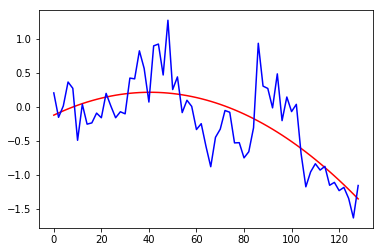

In [24]:
est_trend = estimator.predict(design_matrix)
plot(x, est_trend, '-r', 
     x, bold, '-b')

- And if you simply subtract, you will get the detrended data

(0, 128)

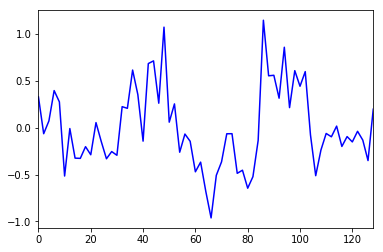

In [25]:
detrended_bold = bold - est_trend
plot(x, detrended_bold, '-b')
plt.xlim(0, 128)

- From here, you can fit your model into this data same way

In [26]:
design_matrix = trimmed_response_model[:, np.newaxis]
estimator.fit(design_matrix, detrended_bold)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- Like previous case,

\begin{align}
Y & = \beta X + \epsilon
\end{align}

- where $Y$ is *'detrended_bold'*, $\beta$ will be estimated from this estimator which is indicating relative strength of the response, and $X$ is *'design matrix'*, which only has our response model as component. In this particular case, as we mentioned first secsion, the $\epsilon$ will be the error(noise) term.
- After fit your data, you can check how the regression analysis is performed well by plotting your estimation and your signal together.

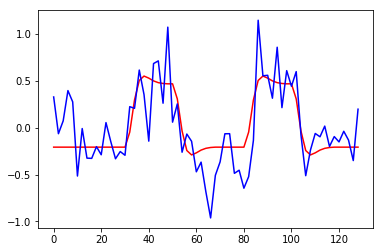

In [27]:
fitted_model = estimator.predict(design_matrix)
plot(x, fitted_model, '-r',
     x, detrended_bold, '-b')

- And also by checking the residual signal

(array([ 1.,  1.,  3.,  2.,  4.,  7.,  7.,  7., 10.,  7.,  5.,  2.,  4.,
         2.,  3.]),
 array([-0.69315598, -0.60586189, -0.51856779, -0.43127369, -0.34397959,
        -0.25668549, -0.16939139, -0.08209729,  0.0051968 ,  0.0924909 ,
         0.179785  ,  0.2670791 ,  0.3543732 ,  0.4416673 ,  0.5289614 ,
         0.61625549]),
 <a list of 15 Patch objects>)

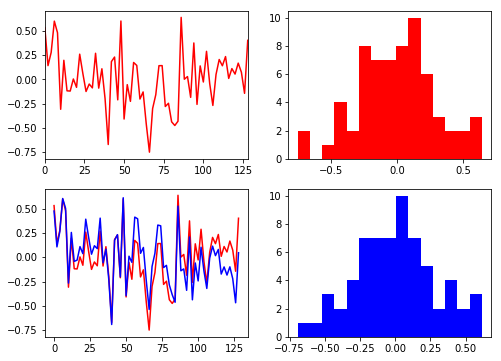

In [28]:
residual = detrended_bold - fitted_model

fig, ax = plt.subplots(2, 2, figsize=[8, 6]) 
# with 2 by 2 subplots, you can index it as 2 by 2 matrix as to target each plot location.
ax[0, 0].plot(x, residual, '-r')
ax[0, 1].hist(residual, bins=15, color='red')
ax[0, 0].set_xlim([0, 128])
ax[1, 0].plot(x, residual, '-r', 
              x, error, '-b')
ax[1, 1].hist(error, bins=15, color='blue')

- Let's see if we can improve this by putting all components on one design matrix and perform only one linear regression.

In [29]:
design_matrix = np.concatenate([pn_curves, trimmed_response_model[:, np.newaxis]], axis=1)

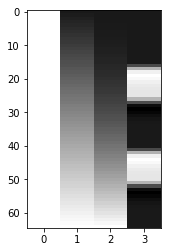

In [30]:
imshow(design_matrix, aspect=0.1, cmap='gray')

In [31]:
estimator.fit(design_matrix, bold)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- This time, we are using more large design metrix, and will apply only one linear regression. Applying at once actually help the performance because each estimation has a chance to create error. (if you apply the regression two time separatly, the chance of error event happen two time.
- This time, the linear equation of the signal is shown as below.

<img src="images/figure_4-3.png" alt="Drawing" style="width: 400px;"/>

- where $Y$ is *'bold'* we acquired from the MR scanner, $\beta$ will be estimated from this estimator, and $X$ is *'design matrix'*, which contains polynomial features and our response model as components. And lastly, the $\epsilon$ will be the error(noise) term again.

- In some literature, the model matrix '$X$' is represented as the heatmap as shown above output of `imshow` plot.
- Let's check the results again.

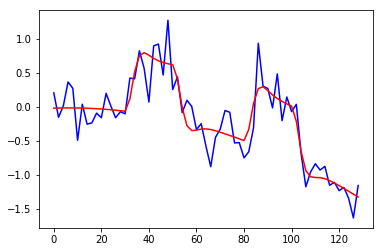

In [32]:
results = estimator.predict(design_matrix)
plot(x, bold, '-b',
     x, results, '-r')

- and residual will be looks like

(array([ 1.,  1.,  3.,  2.,  4.,  7.,  7.,  7., 10.,  7.,  5.,  2.,  4.,
         2.,  3.]),
 array([-0.69315598, -0.60586189, -0.51856779, -0.43127369, -0.34397959,
        -0.25668549, -0.16939139, -0.08209729,  0.0051968 ,  0.0924909 ,
         0.179785  ,  0.2670791 ,  0.3543732 ,  0.4416673 ,  0.5289614 ,
         0.61625549]),
 <a list of 15 Patch objects>)

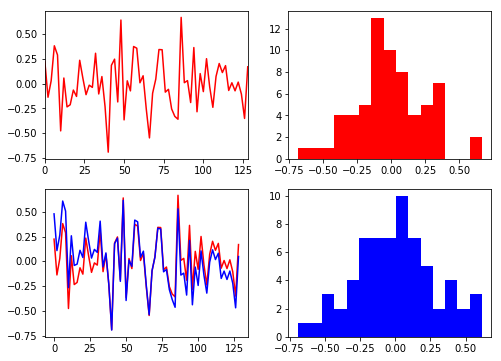

In [33]:
residual = bold - results

fig, ax = plt.subplots(2, 2, figsize=[8, 6])
ax[0, 0].plot(x, residual, '-r')
ax[0, 1].hist(residual, bins=15, color='red')
ax[0, 0].set_xlim([0, 128])
ax[1, 0].plot(x, residual, '-r', 
              x, error, '-b')
ax[1, 1].hist(error, bins=15, color='blue')

- As you can see, the error we added and residual from regression analysis looks more similar than previous case.
- You can check the method score using an attribute `score` in estimater as below.

In [34]:
help(estimator.score)

Help on method score in module sklearn.base:

score(self, X, y, sample_weight=None) method of sklearn.linear_model.base.LinearRegression instance
    Returns the coefficient of determination R^2 of the prediction.
    
    The coefficient R^2 is defined as (1 - u/v), where u is the residual
    sum of squares ((y_true - y_pred) ** 2).sum() and v is the total
    sum of squares ((y_true - y_true.mean()) ** 2).sum().
    The best possible score is 1.0 and it can be negative (because the
    model can be arbitrarily worse). A constant model that always
    predicts the expected value of y, disregarding the input features,
    would get a R^2 score of 0.0.
    
    Parameters
    ----------
    X : array-like, shape = (n_samples, n_features)
        Test samples.
    
    y : array-like, shape = (n_samples) or (n_samples, n_outputs)
        True values for X.
    
    sample_weight : array-like, shape = [n_samples], optional
        Sample weights.
    
    Returns
    -------
    score : 

- Our score is.....

In [35]:
estimator.score(design_matrix, bold)

0.8243939291499648

- This article briefly explains how to apply linear regression analysis to analyze fMRI data using generated fake data.
- To understand more intuitively, try the assignment below. This will greatly improve your python coding skill and your understanding of fMRI data analysis.

### Assignment
- Material need to prepare
    1. sample data of Session 2.
    2. the mask of M1 region that you had drawn on Session 3.
- Trucate the data to have only 65 time points.
>```
(hint)
trimmed_data = data[:,:,:,:65]
```
- get coordinate from the M1 mask to use as indices.
>```
(hint)
indices = np.transpose(np.nonzero(mask_data))
```
- Add response model into the M1 region, estimate the noise level of data, and multiply constant value to the model to create response that shows SNR = 4.
>```
(hint)
SNR = 4
adjusted_response_model = response_model * data.std() * SNR
for i, t, k in indices:
    trimmed_data[i, t, k] += adjusted_response_model
```

- Save as new nifti format image.
>```
(hint)
nii = nib.Nifti1Image(trimmed_data, img.affine)
nii.to_filename('fake_task_fMRI.nii.gz')
```
- Using this modified trimmed data, try task base analysis with model metrix provided here. 
- In addition, please describe the reason why we are taking fourth vector of coefficient (index 3) in the example code below.
>```
(hint)
x, y, z, t = trimmed_data.shape
response_strength = np.zeros([x, y, z])
indices = np.transpose(np.nonzero(trimmed_data.mean(-1))
for i, t, k in indices:
    estimator.fit(model_maxtrix, trimmed_data[i, t, k])
    response_strength[i, t, k] = estimator.coef_[3]
```
- Normalize the distribution of all voxel values to the standard distribution.
>```
(hint)
mean_val = response_strength.mean()
std_val = response_strength.std()
norm_output = (response_strength - mean_val) / std_val
```
- Lastly, save the `norm_output` into the nifti file 'estimated_M1.nii.gz'.